# Processing Embayment Constriction Mesurements

Google earth was used to measure the morphological characteristics to determine the Constriction Ratio of large coastal features around the world. This analysis will use k-means clustering to assess whether or not ther is a suitable subset of large coastal features which can be morphologically classified as Large 'Embayments'. The geological composition (Bedrock/Regolith) of the confining morphological structures can then be used to separate Barrier Estuaries from Large Structural Embayments (LSEs).

## Constriction Ratio

The constriction ratio is the ratio between the width of the mouth of a coastal feature at its thinnest point (L<sub>m</sub>), to the width of the embayed body of water at its widest point (L<sub>b</sub>) [Figure 1](#fig1).

<center>
    <a name="fig1">
        <img src="./test2.png" alt="drawing" width="300" />
    </a>
</center>


The constriction ratio is then given by the equation:

\begin{align}
C = L_m/L_b
\end{align}



## Mesuring Embayments on Google Earth

Identification of Coastal Features was peformed with an altitude set at 300km. Once a large coastal feature was identified, parameter measurement was conducted at a lower altitude to facilitate accurate measurment. Due to the real-world morphological complexity of Coastal Features, L<sub>m</sub> was measureed in multiple parts for Coastal Features with numerous significant mouths [Figure 2](#fig2).

<a name="fig2">
    <img src="./ComplexMorph.jpg" alt="ComplexMorph" width="1000"/>
</a>




## Cleaning Data

Measurements were manually recorded in Excel and then saved to a .csv file for cleaning and statistical analysis with Python. Because Lat and Long point measurements were recorded ([see pin in figure 2](#fig2)), GeoPandas will be used to import and clean the dataset.

### Importing data
Data is imported using geopands and the first 4 entries are displayed to provide a better sense of the dataset.

In [30]:
import pandas as pd
import xlrd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import dms2dd as dd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

```note
Note: %matplotlib inline is used so that graphs are displayed in jupyter notebooks
```

In [3]:
df = pd.read_excel("./EmbaymentData_Basic.xlsx", header=0)

In [4]:
df.head()

,Embayment,Descriptor,Type 1,Type 2,P Lat,P Long,Lm,Lb,C
0,Bay of Marajó,Bay,NaN,NaN,"0°39'57.20""S","48°19'12.53""W",59760,29500,2.025763
1,Gulf of Tumaco,Gulf,Tidal Inlet,NaN,"1°52'31.69""N","78°38'18.96""W",19813,24194,0.818922
2,Bay of São Marcos,Bay,Macrotidal,NaN,"2°36'42.44""S","44°27'57.05""W",12822,24959,0.513723
3,Gulf of Guayaquil,Gulf,Macrotidal,Tidal Inlet,"3° 1'0.98""S","80° 1'17.33""W",31957,26263,1.216807
4,Bay of Malaga,Bay,Tidal Inlet,Ria,"4° 1'32.60""N","77°16'39.67""W",2788,8050,0.346335


In [5]:
df.columns

Index(['Embayment', 'Descriptor', 'Type 1', 'Type 2', 'P Lat', 'P Long', 'Lm',
       'Lb', 'C'],
      dtype='object')

### Cleaning
The relevant colums are:
- Embayment
- Type 1
- Margin
- Ocean/Water Body
- Climate Zone (Koppen)
- Regional Process Dominance
- P Lat
- P Long
- Lm
- Lb
- C

These will be subsetted from the dataset.

In [6]:
df2 = df[['Embayment', 
             'Type 1',
             'P Lat',
             'P Long',
             'Lm',
             'Lb',
             'C']]

          #'Margin',
            #'Ocean/Water Body',
             #'Climate Zone (Koppen)',
             #'Regional Process Dominance',
             

In [7]:
df2.head()

,Embayment,Type 1,P Lat,P Long,Lm,Lb,C
0,Bay of Marajó,NaN,"0°39'57.20""S","48°19'12.53""W",59760,29500,2.025763
1,Gulf of Tumaco,Tidal Inlet,"1°52'31.69""N","78°38'18.96""W",19813,24194,0.818922
2,Bay of São Marcos,Macrotidal,"2°36'42.44""S","44°27'57.05""W",12822,24959,0.513723
3,Gulf of Guayaquil,Macrotidal,"3° 1'0.98""S","80° 1'17.33""W",31957,26263,1.216807
4,Bay of Malaga,Tidal Inlet,"4° 1'32.60""N","77°16'39.67""W",2788,8050,0.346335


In [8]:
df2.describe()

,Lm,Lb,C
count,109.000000,109.000000,108.000000
mean,15900.614679,28514.917431,0.567908
std,18513.732206,22815.635475,0.498723
min,135.000000,2605.000000,0.006635
25%,2122.000000,12263.000000,0.154916
50%,8371.000000,21660.000000,0.415416
75%,23507.000000,40235.000000,0.896912
max,80096.000000,120752.000000,2.609228


### Removing NA and #DIV/0!

Many of these cells do not have appropriate values in them. Because a fomula was applied across the C column in Excel, many NA values are actually read as #DIV/0!.

These will need to be removed alongside entries with little to no data entered. Since the main focus of this portion of the study is the C ratio, rows without Lm or Lb values will be removed and #DIV/0! values will be removed alongside them.

First we will replace empty values with numpys NaN using regex.

In [9]:
df2 = df2.replace('', np.nan)

#### Removing NaN

Pandas DataFrame.dropna() with the option subset=[] is used to drop rows where the L<sub>m</sub> and L<sub>b</sub> parameters are not measured.

In [43]:
dfclean = df.dropna(subset=['Lm', 'Lb', 'P Lat', 'P Long'])

In [44]:
dfclean

,Embayment,Descriptor,Type 1,Type 2,P Lat,P Long,Lm,Lb,C
0,Bay of Marajó,Bay,NaN,NaN,"0°39'57.20""S","48°19'12.53""W",59760,29500,2.025763
1,Gulf of Tumaco,Gulf,Tidal Inlet,NaN,"1°52'31.69""N","78°38'18.96""W",19813,24194,0.818922
2,Bay of São Marcos,Bay,Macrotidal,NaN,"2°36'42.44""S","44°27'57.05""W",12822,24959,0.513723
3,Gulf of Guayaquil,Gulf,Macrotidal,Tidal Inlet,"3° 1'0.98""S","80° 1'17.33""W",31957,26263,1.216807
4,Bay of Malaga,Bay,Tidal Inlet,Ria,"4° 1'32.60""N","77°16'39.67""W",2788,8050,0.346335
...,...,...,...,...,...,...,...,...,...
101,Willapa Bay,Bay,Barrier Estuary,NaN,"46°34'7.17""N","123°58'59.52""W",6984,40235,0.173580
102,Awarua Bay,Bay,Tidal Inlet,Bar Est.,"46°34'7.50""S","168°20'18.14""E",666,5575,0.119462
103,Paterson Inlet,Inlet,LSE,NaN,"46°55'53.55""S","168° 5'18.60""E",1529,6222,0.245741
104,Grays Harbour,Harbour,Barrier Estuary,NaN,"46°56'8.80""N","124° 3'9.33""W",3380,20147,0.167767


## Removing Whitespace

Because this data was entered manually, there are often whitespaces at the end of string which can affect grouping later on. So we will remove these:

In [45]:
def clean(x):
    if isinstance(x, str):
        return x.strip('')
    else:
        pass

dfclean.apply( lambda x: clean(x))

Embayment     None
Descriptor    None
Type 1        None
Type 2        None
P Lat         None
P Long        None
Lm            None
Lb            None
C             None
dtype: object

### Data Types
Many of the datatypes in this table are now wrong

In [46]:
dfclean.dtypes

Embayment      object
Descriptor     object
Type 1         object
Type 2         object
P Lat          object
P Long         object
Lm              int64
Lb              int64
C             float64
dtype: object

## Data Analysis

In this section, I will analyse the dataset using:
 - graphical analysis 
     - Scatter
     - Violin plot
 - anova and post hoc Tukeys (TBD)
     - First testing for anova assumptions
     - Kruskal-Wallis for non-parametric
 - a k-means cluster analysis 
 
to group Coastal Features by C ratio. This should help to determine whether or not there is a LSE subclass. But first we will plot the coastal features as a scatter plot to see their distribution. 

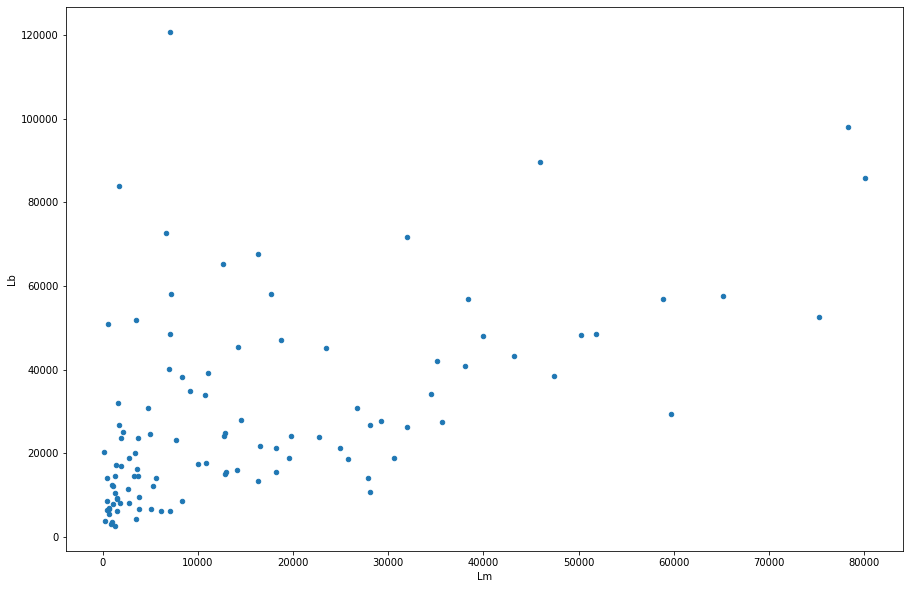

In [47]:
dfclean.plot.scatter(x='Lm', y='Lb')

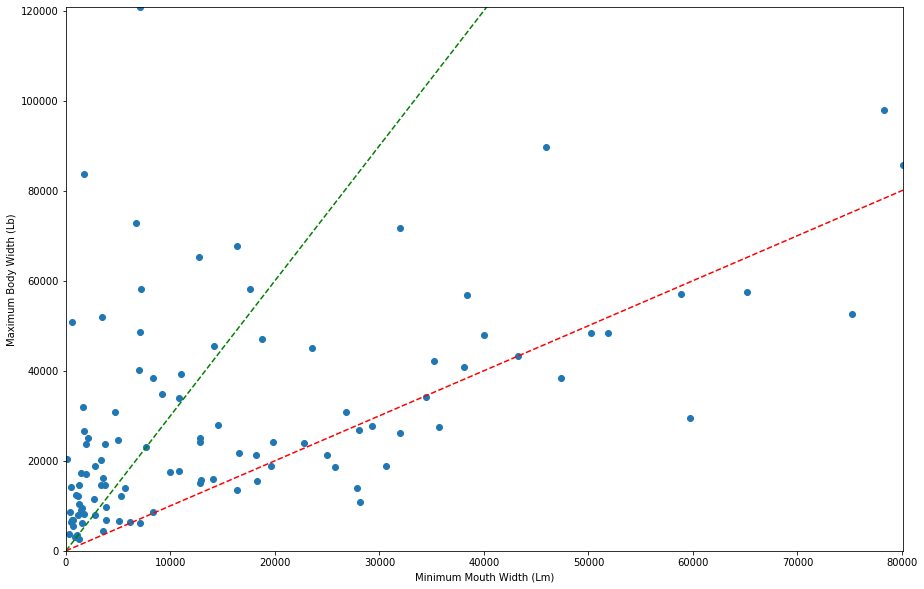

In [48]:
#colours for scatter


plt.scatter(x=dfclean['Lm'], y=dfclean['Lb'])
x=np.linspace(0, max(dfclean['Lb']), 100)
y=x
y2=3*x
plt.plot(x, y, 'r--')
plt.plot(x, y2, 'g--')
plt.axis([0, max(dfclean['Lm']), 0, max(dfclean['Lb'])])
plt.xlabel('Minimum Mouth Width (Lm)')
plt.ylabel('Maximum Body Width (Lb)')

plt.savefig("./images/ScatterPlot.svg")
plt.savefig("./images/ScatterPlot.png")

plt.show()

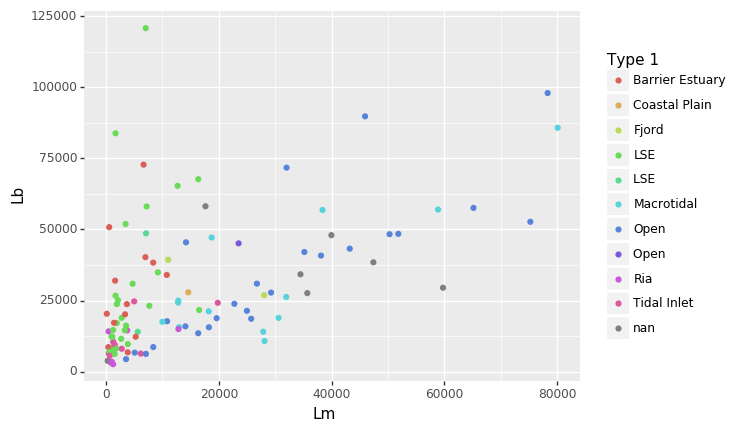

<ggplot: (7026272701)>

In [32]:
#The same plot using plotnine
graph = ggplot(aes(x='Lm', y='Lb'),dfclean)
graph = graph + geom_point(aes(color='Type 1'))
graph

In this instance, the further away a point is from the red line, the more embayed a coastal feature is. The green line represents:
\begin{align}
\frac{L_m}{3L_b}
\end{align}
Which can also be stated as as $C=0.3$, an consequently anything above the ***green*** line is $< C=0.3$ and considered 'Embayed'. Additionally, any points on or below ***red*** line are considered open and the further away they are from the ***red*** line they are the more hypersynchronous they are.


### Global Distribution

The distribution of Coastal Features reviewed for this literature review can be displayed using geopandas. However geopandas works best if the latitude and longitude are in ***Decimal Degrees*** rather than their current format ***Degrees Minutes Seconds***. To solve this I have written a simple function which converts from ***DMS*** to ***DD***. This function can be applied to both latitude and longitude and then those values will be stored in a list alongside the ***Point*** geometry type for later plotting.

First conversion from ***DMS*** to ***DD***. Notethe use of custom scrip dd.convert

In [16]:
dfclean.loc[:,'Lat'] = dfclean.loc[:,'P Lat'].apply(dd.convert)
dfclean.loc[:,'Long'] = dfclean.loc[:,'P Long'].apply(dd.convert)


/Users/tinabaum/anaconda3/envs/embayments/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tinabaum/anaconda3/envs/embayments/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
dfclean.head()

,Embayment,Descriptor,Type 1,Type 2,P Lat,P Long,Lm,Lb,C,Lat,Long
0,Bay of Marajó,Bay,NaN,NaN,"0°39'57.20""S","48°19'12.53""W",59760,29500,2.025763,-0.665889,-48.320147
1,Gulf of Tumaco,Gulf,Tidal Inlet,NaN,"1°52'31.69""N","78°38'18.96""W",19813,24194,0.818922,1.875469,-78.638600
2,Bay of São Marcos,Bay,Macrotidal,NaN,"2°36'42.44""S","44°27'57.05""W",12822,24959,0.513723,-2.611789,-44.465847
3,Gulf of Guayaquil,Gulf,Macrotidal,Tidal Inlet,"3° 1'0.98""S","80° 1'17.33""W",31957,26263,1.216807,-3.016939,-80.021481
4,Bay of Malaga,Bay,Tidal Inlet,Ria,"4° 1'32.60""N","77°16'39.67""W",2788,8050,0.346335,4.025722,-77.277686


Now we convert the DD lat long into Points from the Shapely.geometry module by:

In [18]:
geometry = [Point(x,y) for x,y in zip(dfclean['Long'], dfclean['Lat'])]

gfd=gpd.GeoDataFrame(dfclean, geometry=geometry)

Importing a world map to plot against:

In [19]:
world_url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson'
world = gpd.read_file(world_url)

In [20]:
world.head()

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
0,3,5,Netherlands,NL1,1,2,Country,Aruba,ABW,0,...,Americas,Caribbean,Latin America & Caribbean,5,5,5,4,-99,Admin-0 country,"POLYGON ((-69.89912109375 12.45200195312499, -..."
1,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,0,...,Asia,Southern Asia,South Asia,11,11,4,-99,1,Admin-0 country,"POLYGON ((74.89130859375001 37.231640625, 74.8..."
2,1,3,Angola,AGO,0,2,Sovereign country,Angola,AGO,0,...,Africa,Middle Africa,Sub-Saharan Africa,6,6,4,-99,1,Admin-0 country,"(POLYGON ((14.19082031250008 -5.8759765625, 14..."
3,1,6,United Kingdom,GB1,1,2,Dependency,Anguilla,AIA,0,...,Americas,Caribbean,Latin America & Caribbean,8,8,4,-99,-99,Admin-0 country,"POLYGON ((-63.001220703125 18.22177734374999, ..."
4,1,6,Albania,ALB,0,2,Sovereign country,Albania,ALB,0,...,Europe,Southern Europe,Europe & Central Asia,7,7,4,-99,1,Admin-0 country,"POLYGON ((20.06396484375 42.547265625, 20.1035..."


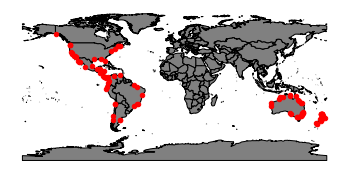

In [21]:
f, ax = plt.subplots(1)

world.plot(ax=ax, color='grey', edgecolor='black')

gfd.plot(ax=ax, marker='o', color='red', markersize=20)

plt.axis("off")

plt.savefig('./images/EmbaymentsWorld.svg')
plt.savefig('./images/EmbaymentsWorld.png')


# ***Ward Agglomerative Clustering***


Clustering analysis of the embayment measurements should yield morphological archetypes for large coastal features. This analysis will be conducted here using the kmeans module from sklearn.cluster package.First we create a subset of dfclean (because it is a Pandas DataFrame not a Geopandas GeoDataFrame) and store it in the variable ***X***. Then we set up the model options and store them in the variable ***kmeans***. Lastly, we create the model by applying the _KMeans.fit(X)_ method and store it in ***kluster***. ***kluster*** now contains the model and centroids for the cluster analysis that we just performed. 

### Using K-Means

I have modified this notebook to use instead AgglomerativeClustering from sklearn using the Ward method. Kmeans methods have been commented out but are still available to view. 

In [22]:
from sklearn.cluster import KMeans

X = dfclean[dfclean.loc[:,'Lm'].notna() & dfclean.loc[:,'Lb'].notna()]
kmeans = KMeans(n_clusters=7, max_iter=10000)
kluster = kmeans.fit(X.loc[:,["Lm","Lb"]])

### Cluster Centers

The computed cluster centers (we specified 3) are stored in the attribute ***cluster_centers_***. Calling this attribute shows that the centroid coordinates are stored in a numpy array (may be useful to know).

In [23]:
kluster.cluster_centers_


array([[ 23581.19047619,  22534.33333333],
       [ 68115.33333333,  91153.        ],
       [  3596.59183673,  12538.14285714],
       [  9250.84615385,  41437.30769231],
       [ 50286.41666667,  46907.08333333],
       [  7043.        , 120752.        ],
       [ 13464.        ,  68217.14285714]])

### Determining Cluster Category

Determination of each points 'Cluster' is done by applying the ***predict()*** method for each point in the DataFrame ***X***. Here we store those values in the column ***'Cluster'***.

In [99]:
X['Cluster'] = kluster.fit_predict(X.loc[:,["Lm","Lb"]])

In [100]:
X

,Embayment,Descriptor,Type 1,Type 2,P Lat,P Long,Lm,Lb,C,Lat,Long,geometry,Cluster
0,Bay of Marajó,Bay,NaN,NaN,"0°39'57.20""S","48°19'12.53""W",59760,29500,2.025763,-0.665889,-48.320147,POINT (-48.32014722222223 -0.6658888888888889),1
1,Gulf of Tumaco,Gulf,Tidal Inlet,NaN,"1°52'31.69""N","78°38'18.96""W",19813,24194,0.818922,1.875469,-78.638600,POINT (-78.63860000000001 1.875469444444444),0
2,Bay of São Marcos,Bay,Macrotidal,NaN,"2°36'42.44""S","44°27'57.05""W",12822,24959,0.513723,-2.611789,-44.465847,POINT (-44.46584722222222 -2.611788888888889),0
3,Gulf of Guayaquil,Gulf,Macrotidal,Tidal Inlet,"3° 1'0.98""S","80° 1'17.33""W",31957,26263,1.216807,-3.016939,-80.021481,POINT (-80.02148055555556 -3.016938888888889),0
4,Bay of Malaga,Bay,Tidal Inlet,Ria,"4° 1'32.60""N","77°16'39.67""W",2788,8050,0.346335,4.025722,-77.277686,POINT (-77.27768611111111 4.025722222222222),3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Willapa Bay,Bay,Barrier Estuary,NaN,"46°34'7.17""N","123°58'59.52""W",6984,40235,0.173580,46.568658,-123.983200,POINT (-123.9832 46.56865833333334),6
102,Awarua Bay,Bay,Tidal Inlet,Bar Est.,"46°34'7.50""S","168°20'18.14""E",666,5575,0.119462,-46.568750,168.338372,POINT (168.3383722222222 -46.56875),3
103,Paterson Inlet,Inlet,LSE,NaN,"46°55'53.55""S","168° 5'18.60""E",1529,6222,0.245741,-46.931542,168.088500,POINT (168.0885 -46.93154166666667),3
104,Grays Harbour,Harbour,Barrier Estuary,NaN,"46°56'8.80""N","124° 3'9.33""W",3380,20147,0.167767,46.935778,-124.052592,POINT (-124.0525916666667 46.93577777777777),3


### Graphing

Now we can graphically display the cluster grouping using matplotlib.

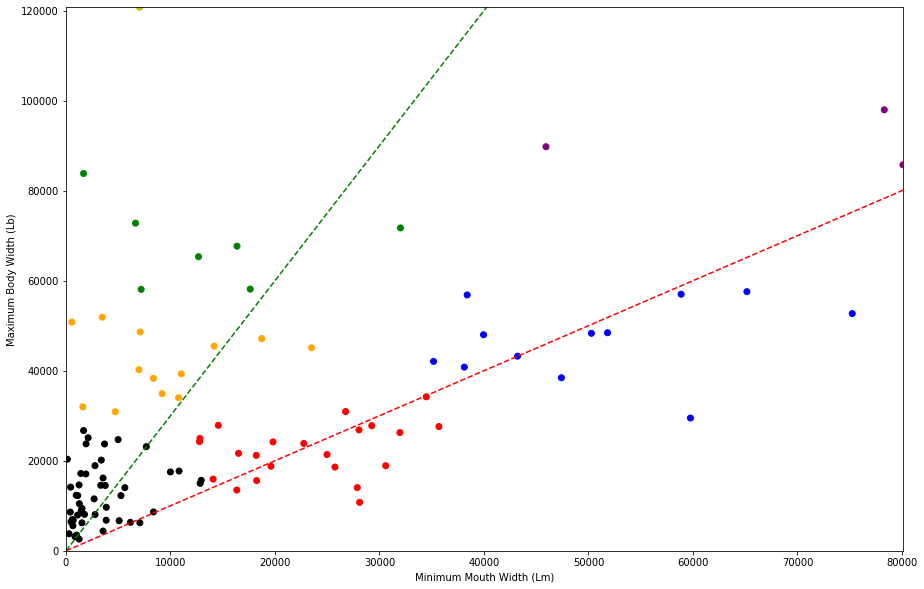

In [101]:

colours={0:'r',1:'b', 2:'g', 3:'black', 4: 'y', 5: 'purple', 6:'orange'}

plt.scatter(x=X['Lm'], y=X['Lb'], c=X['Cluster'].apply(lambda x: colours[x]))
x=np.linspace(0, max(X['Lb']), 100)
y=x
y2=3*x
plt.plot(x, y, 'r--')
plt.plot(x, y2, 'g--')
plt.axis([0, max(dfclean['Lm']), 0, max(dfclean['Lb'])])
plt.xlabel('Minimum Mouth Width (Lm)')
plt.ylabel('Maximum Body Width (Lb)')

plt.savefig('./images/Kluster1.svg')  # Saving the image
plt.savefig("./images/Kluster1.png")

plt.show()   # Showing the graph


In [102]:
X.loc["Type 1"] = X["Type 1"].str.strip()
X.loc["Cluster"] = X["Cluster"].apply(lambda x: str(x))
histdf = X.groupby(["Type 1", "Cluster"])
histdf.count()

Embayment  Descriptor  Type 2  P Lat  P Long  Lm  Lb  \
Type 1          Cluster                                                         
BAR EST.        3.0              1           1       1      1       1   1   1   
Barrier Estuary 2.0              1           1       1      1       1   1   1   
                3.0              6           6       3      6       6   6   6   
                6.0              5           5       0      5       5   5   5   
Coastal Plain   0.0              1           1       0      1       1   1   1   
Fjord           0.0              1           1       1      1       1   1   1   
                6.0              1           1       1      1       1   1   1   
LSE             0.0              1           1       1      1       1   1   1   
                2.0              4           4       2      4       4   4   4   
                3.0             18          18      12     18      18  18  18   
                4.0              1           1       1      1       1   1   1   
                6.0              3           3       1      3       3   3   3   
LSE             3.0              1           1       0      1       1   1   1   
                6.0              1           1       0      1       1   1   1   
Macrotidal      0.0              7           7       5      7       7   7   7   
                1.0              2           2       1      2       2   2   2   
                3.0              2           2       1      2       2   2   2   
                5.0              1           1       0      1       1   1   1   
                6.0              1           1       0      1       1   1   1   
OPN             3.0              2           2       1      2       2   2   2   
Open            0.0              9           9       1      9       9   9   9   
                1.0              7           7       0      7       7   7   7   
                2.0              1           1       1      1       1   1   1   
                3.0              3           3       0      3       3   3   3   
                5.0              2           2       1      2       2   2   2   
                6.0              1           1       1      1       1   1   1   
Open            6.0              1           1       1      1       1   1   1   
Ria             3.0              6           6       5      6       6   6   6   
TDL             3.0              1           1       1      1       1   1   1   
Tidal Inlet     0.0              1           1       0      1       1   1   1   
                3.0              7           7       4      7       7   7   7   

                          C  Lat  Long  geometry  
Type 1          Cluster                           
BAR EST.        3.0       1    1     1         1  
Barrier Estuary 2.0       1    1     1         1  
                3.0       6    6     6         6  
                6.0       5    5     5         5  
Coastal Plain   0.0       1    1     1         1  
Fjord           0.0       1    1     1         1  
                6.0       1    1     1         1  
LSE             0.0       1    1     1         1  
                2.0       4    4     4         4  
                3.0      17   18    18        18  
                4.0       1    1     1         1  
                6.0       3    3     3         3  
LSE             3.0       1    1     1         1  
                6.0       1    1     1         1  
Macrotidal      0.0       7    7     7         7  
                1.0       2    2     2         2  
                3.0       2    2     2         2  
                5.0       1    1     1         1  
                6.0       1    1     1         1  
OPN             3.0       2    2     2         2  
Open            0.0       9    9     9         9  
                1.0       7    7     7         7  
                2.0       1    1     1         1  
                3.0       3    3     3         3  
                5.0      

### Subsetting Data

As you can see, a large potion of the classified data is a part of cluster 0. This could be due to the distribution of other clusters on the euclidean plane. The next step is to remove the sparse points and re-calculate the clustering model. This should be able to provide more appropriate clustering for the dataset. It may be worthwhile reclassifying the sparse points as 'Massive' coastal features. These are not really the concern of this study but it is useful to know that they form a cluster.

Next we will remove all features with a ***L<sub>m</sub>*** greater than 15000m.

In [103]:
dfcsub = dfclean[dfclean['Lm'] < 15000]
dfcsub

,Embayment,Descriptor,Type 1,Type 2,P Lat,P Long,Lm,Lb,C,Lat,Long,geometry
2,Bay of São Marcos,Bay,Macrotidal,NaN,"2°36'42.44""S","44°27'57.05""W",12822,24959,0.513723,-2.611789,-44.465847,POINT (-44.46584722222222 -2.611788888888889)
4,Bay of Malaga,Bay,Tidal Inlet,Ria,"4° 1'32.60""N","77°16'39.67""W",2788,8050,0.346335,4.025722,-77.277686,POINT (-77.27768611111111 4.025722222222222)
6,Montijo Bay,Bay,Macrotidal,Tidal Inlet,"7°40'7.18""N","81° 8'1.33""W",12943,15653,0.826870,7.668661,-81.133703,POINT (-81.13370277777778 7.668661111111112)
7,Bahia de Muertos,Bay,Tidal Inlet,NaN,"8°16'7.45""N","82°15'34.02""W",1281,10471,0.122338,8.268736,-82.259450,POINT (-82.25945 8.268736111111112)
8,North Bay,Bay,Macrotidal,Tidal Inlet,"8°20'29.19""N","78°17'35.05""W",12785,24255,0.527108,8.341442,-78.293069,POINT (-78.29306944444444 8.341441666666666)
...,...,...,...,...,...,...,...,...,...,...,...,...
99,Columbia River Estuary,Estuary,Barrier Estuary,Ria,"46°12'57.47""N","123°50'37.45""W",5263,12263,0.429177,46.215964,-123.843736,POINT (-123.8437361111111 46.21596388888889)
101,Willapa Bay,Bay,Barrier Estuary,NaN,"46°34'7.17""N","123°58'59.52""W",6984,40235,0.173580,46.568658,-123.983200,POINT (-123.9832 46.56865833333334)
102,Awarua Bay,Bay,Tidal Inlet,Bar Est.,"46°34'7.50""S","168°20'18.14""E",666,5575,0.119462,-46.568750,168.338372,POINT (168.3383722222222 -46.56875)
103,Paterson Inlet,Inlet,LSE,NaN,"46°55'53.55""S","168° 5'18.60""E",1529,6222,0.245741,-46.931542,168.088500,POINT (168.0885 -46.93154166666667)


In [104]:
dfcsub.describe()

,Lm,Lb,C,Lat,Long
count,68.000000,68.000000,67.000000,68.000000,68.000000
mean,4848.764706,22627.073529,0.294430,-8.707631,38.974243
std,4273.746049,21218.175774,0.273465,32.474718,126.112512
min,135.000000,2605.000000,0.006635,-46.931542,-124.052592
25%,1386.750000,8480.000000,0.089805,-36.498810,-82.334213
50%,3510.500000,15786.000000,0.202073,-29.277657,43.222458
75%,7122.500000,26999.500000,0.400290,22.856097,172.656597
max,14581.000000,120752.000000,1.135882,46.935778,176.001297


#### Removed Data

The removed data are:

In [105]:
dfcremoved = dfclean[dfclean['Lm'] > 15000]
dfcremoved

,Embayment,Descriptor,Type 1,Type 2,P Lat,P Long,Lm,Lb,C,Lat,Long,geometry
0,Bay of Marajó,Bay,NaN,NaN,"0°39'57.20""S","48°19'12.53""W",59760,29500,2.025763,-0.665889,-48.320147,POINT (-48.32014722222223 -0.6658888888888889)
1,Gulf of Tumaco,Gulf,Tidal Inlet,NaN,"1°52'31.69""N","78°38'18.96""W",19813,24194,0.818922,1.875469,-78.638600,POINT (-78.63860000000001 1.875469444444444)
3,Gulf of Guayaquil,Gulf,Macrotidal,Tidal Inlet,"3° 1'0.98""S","80° 1'17.33""W",31957,26263,1.216807,-3.016939,-80.021481,POINT (-80.02148055555556 -3.016938888888889)
5,Sechura Bay,Bay,Open,NaN,"5°37'31.22""S","80°59'58.82""W",51831,48446,1.069872,-5.625339,-80.999672,POINT (-80.99967222222222 -5.62533888888889)
10,Chiriqui Lagoon,Lagoon,NaN,NaN,"9° 3'24.23""N","82° 4'24.18""W",17635,58136,0.303340,9.056731,-82.073383,POINT (-82.07338333333333 9.056730555555557)
11,Gulf of Nicoya,Gulf,Macrotidal,NaN,"9°53'15.63""N","84°49'23.76""W",30602,18906,1.618640,9.887675,-84.823267,POINT (-84.82326666666667 9.887675)
16,Gulf of Fonseca,Gulf,Open,Tidal Inlet,"13° 8'41.84""N","87°38'59.19""W",32011,71729,0.446277,13.144956,-87.649775,POINT (-87.64977500000001 13.14495555555555)
17,Blue Mud Bay,Bay,Open,LSE,"13°25'10.48""S","136° 5'36.98""E",45938,89765,0.511758,-13.419578,136.093606,POINT (136.0936055555556 -13.41957777777778)
18,Princess Charlotte Bay,Bay,Open,NaN,"14°19'6.29""S","143°57'36.30""E",50283,48317,1.040690,-14.318414,143.960083,POINT (143.9600833333333 -14.31841388888889)
19,Cambridge Gulf,Gulf,Macrotidal,Inlet,"14°52'3.49""S","128°14'39.82""E",18212,21209,0.858692,-14.867636,128.244394,POINT (128.2443944444444 -14.86763611111111)


In [106]:
dfcrgroup['Embayment']

Type 1       Descriptor
Fjord        Bay            1
LSE          Frith          1
             Gulf           1
Macrotidal   Bay            2
             Gulf           5
             Sound          2
Open         Bay           16
             Gulf           2
Open         Bay            1
Tidal Inlet  Gulf           1
Name: Embayment, dtype: int64

As you can see the majority of embayments removed during this process were classified as Macrotidal and Open embayments. If we conduct the same measurement on the <15000 dataset we get:

In [108]:
dfcsgroup = dfcsub.groupby(['Type 1', 'Descriptor']).count()
dfcsgroup['Embayment']

Type 1           Descriptor
BAR EST.         Lake           1
Barrier Estuary  Bay            5
                 Estuary        1
                 Harbour        1
                 Lagoon         5
Coastal Plain    Gulf           1
Fjord            Sound          1
LSE              Basin          2
                 Bay           11
                 Harbour        8
                 Inlet          3
                 Lake           1
LSE              Gulf           2
Macrotidal       Bay            4
OPN              Bay            2
Open             Bay            5
Ria              Bay            2
                 Harbour        1
                 Inlet          2
                 Lake           1
TDL              Bay            1
Tidal Inlet      Bay            4
                 Harbour        2
                 Inlet          1
Name: Embayment, dtype: int64

## Second K-means

Now we can conduct a second K-means on the subsetted group.

In [76]:
X_2 = dfcsub
kmeans_2 = KMeans(n_clusters=7, max_iter=10000)
kluster_2 = kmeans_2.fit(X_2.loc[:, ['Lm','Lb']])

In [77]:
kluster_2.cluster_centers_

array([[  7529.57142857,  35664.        ],
       [  2626.125     ,  19106.6875    ],
       [  4174.        ,  78298.        ],
       [  7532.83333333,  53364.16666667],
       [  2438.51851852,   7546.22222222],
       [  7043.        , 120752.        ],
       [ 12062.55555556,  20222.77777778]])

In [78]:
X_2['Cluster'] = kluster_2.predict(X_2.loc[:,['Lm','Lb']]) #kluster_2.fit(X_2.loc[:,['Lm','Lb']])

/Users/tinabaum/anaconda3/envs/embayments/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


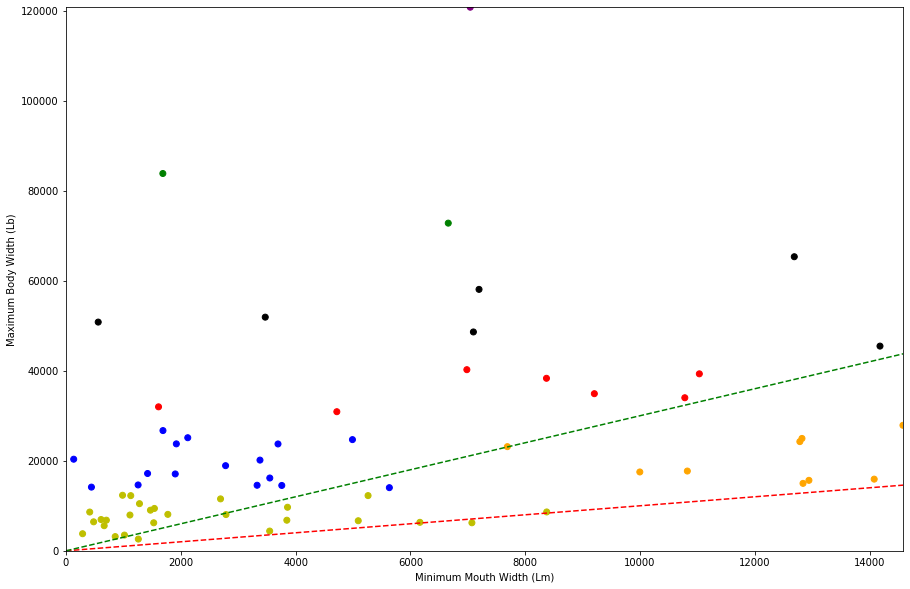

In [79]:
colours={0:'r',1:'b', 2:'g', 3:'black', 4: 'y', 5: 'purple', 6:'orange'}

plt.scatter(x=X_2['Lm'], y=X_2['Lb'], c=X_2['Cluster'].apply(lambda x: colours[x]))
x=np.linspace(0, max(X_2['Lb']), 100)
y=x
y2=3*x
plt.plot(x, y, 'r--')
plt.plot(x, y2, 'g--')
plt.axis([0, max(X_2['Lm']), 0, max(X_2['Lb'])])
plt.xlabel('Minimum Mouth Width (Lm)')
plt.ylabel('Maximum Body Width (Lb)')

plt.savefig('./images/Kluster2_Subset.svg')  #saving images
plt.savefig('./images/Kluster2_Subset.png')  #saving images

plt.show()

This is a preliminary cluster model and more data is required for a more robust clustering method. However lets look at the Cluster counts by Type 1

In [80]:
fin = X_2.groupby(["Cluster", "Type 1"]).count()
fin["Embayment"]

Cluster  Type 1         
0        Barrier Estuary    4
         Fjord              1
         LSE                2
1        Barrier Estuary    4
         LSE                8
         LSE                1
         Ria                2
         Tidal Inlet        1
2        Barrier Estuary    1
         LSE                1
3        Barrier Estuary    1
         LSE                3
         LSE                1
         Open               1
4        BAR EST.           1
         Barrier Estuary    2
         LSE                9
         OPN                2
         Open               2
         Ria                3
         TDL                1
         Tidal Inlet        6
5        LSE                1
6        Coastal Plain      1
         LSE                1
         Macrotidal         4
         Open               2
         Ria                1
Name: Embayment, dtype: int64

Although the Type 1 embayment types are messy these can be summarised as:

|Cluster   | Embayment Type   |   Count   |
|----------|------------------|-----------|
|0         | Barrier Estuary  |    3      |
|          | LSE              |    9      |
|          | Open             |    4      |
|          | Ria              |    3      |
|          | Tidal Inlet      |    7      |
|1         | Barrier Estuary  |    1      |
|          | LSE              |    3      |
|          | Open             |    1      |
|2         | Barrier          |    3      |
|          | LSE              |    6      |
|          | Open             |    2      |
|          | Ria              |    2      |